In [11]:
import geopandas as gpd
import pandas as pd
import rasterio
import glob
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


In [24]:
# --- Configurações ---
PASTA_RASTERS_CORRIGIDOS = r"D:\ARTIGOS\2025\LARANJA_MAX\02_INTERMEDIARIOS\Rasters\bioclim\atual"
PONTOS_OCORRENCIA_PATH = r"D:\ARTIGOS\2025\LARANJA_MAX\03_MAXENT_INPUT\Occurrence\csv\input_traning_70_orange.csv"
PASTA_SAIDA_FEATURES = r"D:\ARTIGOS\2025\LARANJA_MAX\02_INTERMEDIARIOS\Features"
NOME_ARQUIVO_SAIDA = 'features_selecionadas_laranja.csv'
COLUNA_LON = 'long'
COLUNA_LAT = 'lat'
VIF_THRESHOLD = 5
PRIORITY_VARIABLES = [
    'wc2.1_2.5m_bio_1',
    'wc2.1_2.5m_bio_4',
    'wc2.1_2.5m_bio_6',
    'wc2.1_2.5m_bio_12',
    'wc2.1_2.5m_bio_17',
    'wc2.1_2.5m_bio_18'
]

# --- Carregamento ---
os.makedirs(PASTA_SAIDA_FEATURES, exist_ok=True)
print(f"Carregando dados de ocorrência de: {PONTOS_OCORRENCIA_PATH}")
pontos_df = pd.read_csv(PONTOS_OCORRENCIA_PATH)

print("\nDados de ocorrência carregados com sucesso! As 5 primeiras linhas são:")
print(pontos_df.head())

Carregando dados de ocorrência de: D:\ARTIGOS\2025\LARANJA_MAX\03_MAXENT_INPUT\Occurrence\csv\input_traning_70_orange.csv

Dados de ocorrência carregados com sucesso! As 5 primeiras linhas são:
            specie        lat       long
0  Citrus sinensis -13.441987 -41.981797
1  Citrus sinensis   6.329492 -75.540440
2  Citrus sinensis  20.775009  75.175003
3  Citrus sinensis  35.475009   0.325000
4  Citrus sinensis  18.075008 -88.275004


# Passo 2: Extrair Valores das Variáveis Ambientais


In [25]:
print("Iniciando extração de valores dos rasters...")

# Converter o DataFrame de pontos para um formato geoespacial
pontos_gdf = gpd.GeoDataFrame(
    pontos_df,
    geometry=gpd.points_from_xy(pontos_df[COLUNA_LON], pontos_df[COLUNA_LAT]),
    crs="EPSG:4326"
)

# Encontrar e processar cada raster na pasta
lista_rasters = glob.glob(os.path.join(PASTA_RASTERS_CORRIGIDOS, '*.tif'))
raster_names = []

for raster_path in lista_rasters:
    if raster_path.lower().endswith('.tif'):
        raster_name = os.path.splitext(os.path.basename(raster_path))[0]
        raster_names.append(raster_name)
        with rasterio.open(raster_path) as src:
            # Garante que os pontos e o raster estão no mesmo sistema de coordenadas
            pontos_gdf_proj = pontos_gdf.to_crs(src.crs)
            coordenadas_proj = [(p.x, p.y) for p in pontos_gdf_proj.geometry]
            # Extrai os valores
            pontos_df[raster_name] = [val[0] for val in src.sample(coordenadas_proj)]

print(f"\nValores extraídos para {len(raster_names)} variáveis.")
print("Novas colunas foram adicionadas à tabela. Verificando as 5 primeiras linhas:")
print(pontos_df.head())

Iniciando extração de valores dos rasters...

Valores extraídos para 28 variáveis.
Novas colunas foram adicionadas à tabela. Verificando as 5 primeiras linhas:
            specie        lat       long  AWCh1_M_sl4_250m_ll  \
0  Citrus sinensis -13.441987 -41.981797                   12   
1  Citrus sinensis   6.329492 -75.540440                   14   
2  Citrus sinensis  20.775009  75.175003                    4   
3  Citrus sinensis  35.475009   0.325000                   14   
4  Citrus sinensis  18.075008 -88.275004                   11   

   CECSOL_M_sl4_250m_ll  CLYPPT_M_sl4_250m_ll  OCSTHA_M_sd3_250m_ll  \
0                    17                    38                    28   
1                    19                    34                    40   
2                    55                    48                    13   
3                    16                    28                    16   
4                    40                    43                    57   

   PHIHOX_M_sl4_250m_l

# Passo 3: Análise de Correlação (VIF) das Variáveis Prioritárias

In [26]:
# Este comando vai listar todos os nomes das colunas de variáveis ambientais que existem na sua tabela
print("Nomes de todas as variáveis encontradas:")
print(variaveis_df.columns.tolist())

Nomes de todas as variáveis encontradas:
['AWCh1_M_sl4_250m_ll', 'CECSOL_M_sl4_250m_ll', 'CLYPPT_M_sl4_250m_ll', 'OCSTHA_M_sd3_250m_ll', 'PHIHOX_M_sl4_250m_ll', 'slope_world', 'SNDPPT_M_sl4_250m_ll', 'TEXMHT_M_sl4_250m_ll', 'wc2.1_2.5m_bio_1', 'wc2.1_2.5m_bio_10', 'wc2.1_2.5m_bio_11', 'wc2.1_2.5m_bio_12', 'wc2.1_2.5m_bio_13', 'wc2.1_2.5m_bio_14', 'wc2.1_2.5m_bio_15', 'wc2.1_2.5m_bio_16', 'wc2.1_2.5m_bio_17', 'wc2.1_2.5m_bio_18', 'wc2.1_2.5m_bio_19', 'wc2.1_2.5m_bio_2', 'wc2.1_2.5m_bio_3', 'wc2.1_2.5m_bio_4', 'wc2.1_2.5m_bio_5', 'wc2.1_2.5m_bio_6', 'wc2.1_2.5m_bio_7', 'wc2.1_2.5m_bio_8', 'wc2.1_2.5m_bio_9', 'wc2.1_2.5m_elev']


In [27]:
# Primeiro, criamos uma tabela limpa apenas com as variáveis ambientais, removendo linhas com dados faltantes.
# A variável 'raster_names' foi criada no passo anterior e contém o nome de todas as 28 variáveis.
variaveis_df = pontos_df[raster_names].dropna()

print("\n--- Iniciando seleção de variáveis com prioridade ---")
print(f"\n1. Analisando VIF interno das {len(PRIORITY_VARIABLES)} variáveis prioritárias:")

# Filtra o DataFrame para conter apenas as variáveis prioritárias
df_prioritarias = variaveis_df[PRIORITY_VARIABLES]

# Adiciona uma constante, necessária para o cálculo do VIF
df_vif_prioritarias = add_constant(df_prioritarias)

# Calcula o VIF
vif_prioritarias = pd.Series(
    [variance_inflation_factor(df_vif_prioritarias.values, i) for i in range(df_vif_prioritarias.shape[1])],
    index=df_vif_prioritarias.columns
).drop('const') # Remove a constante da lista final

print("\nResultado do VIF para as variáveis prioritárias:")
print(vif_prioritarias)

if vif_prioritarias.max() > VIF_THRESHOLD:
    print(f"\nAVISO: Colinearidade detectada entre as variáveis prioritárias (VIF > {VIF_THRESHOLD}).")
    print("O script manterá estas variáveis, pois são prioritárias, mas é importante estar ciente desta correlação.")


--- Iniciando seleção de variáveis com prioridade ---

1. Analisando VIF interno das 6 variáveis prioritárias:

Resultado do VIF para as variáveis prioritárias:
wc2.1_2.5m_bio_1     inf
wc2.1_2.5m_bio_4     inf
wc2.1_2.5m_bio_6     inf
wc2.1_2.5m_bio_12    inf
wc2.1_2.5m_bio_17    inf
wc2.1_2.5m_bio_18    inf
dtype: float64

AVISO: Colinearidade detectada entre as variáveis prioritárias (VIF > 5).
O script manterá estas variáveis, pois são prioritárias, mas é importante estar ciente desta correlação.


c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


# Passo 4: Seleção Automática das Demais Variáveis


In [28]:
print("\n2. Testando variáveis candidatas para adicionar ao modelo (LÓGICA CORRIGIDA)...")

# Lista das variáveis que serão testadas (já definida nos passos anteriores)
candidate_variables = [v for v in variaveis_df.columns if v not in PRIORITY_VARIABLES]
final_selected_variables = PRIORITY_VARIABLES.copy()

for candidate in candidate_variables:
    temp_selection = final_selected_variables + [candidate]
    df_temp = variaveis_df[temp_selection]
    
    # Adiciona a constante para o cálculo do VIF
    df_vif_temp = add_constant(df_temp)
    
    try:
        # Calcula o VIF para o conjunto temporário
        vif_temp = pd.Series(
            [variance_inflation_factor(df_vif_temp.values, i) for i in range(df_vif_temp.shape[1])],
            index=df_vif_temp.columns
        ).drop('const')
        
        # --- LÓGICA CORRIGIDA AQUI ---
        # Verifica o VIF apenas da variável candidata, e não o VIF máximo de todo o conjunto.
        if vif_temp[candidate] < VIF_THRESHOLD:
            final_selected_variables.append(candidate)
            print(f"  [✓] Adicionada: '{candidate}' (VIF da variável: {vif_temp[candidate]:.2f})")
        else:
            print(f"  [✗] Rejeitada: '{candidate}' (VIF da variável seria: {vif_temp[candidate]:.2f})")
            
    except Exception as e:
        # Captura possíveis erros matemáticos se a colinearidade for perfeita
        print(f"  [✗] Rejeitada: '{candidate}' (Causou erro de cálculo, provavelmente colinearidade perfeita.)")


2. Testando variáveis candidatas para adicionar ao modelo (LÓGICA CORRIGIDA)...
  [✓] Adicionada: 'AWCh1_M_sl4_250m_ll' (VIF da variável: 0.91)
  [✓] Adicionada: 'CECSOL_M_sl4_250m_ll' (VIF da variável: 1.12)
  [✓] Adicionada: 'CLYPPT_M_sl4_250m_ll' (VIF da variável: 0.38)
  [✓] Adicionada: 'OCSTHA_M_sd3_250m_ll' (VIF da variável: 1.12)
  [✓] Adicionada: 'PHIHOX_M_sl4_250m_ll' (VIF da variável: 0.13)
  [✓] Adicionada: 'slope_world' (VIF da variável: 1.12)
  [✓] Adicionada: 'SNDPPT_M_sl4_250m_ll' (VIF da variável: 0.40)
  [✓] Adicionada: 'TEXMHT_M_sl4_250m_ll' (VIF da variável: 1.13)
  [✗] Rejeitada: 'wc2.1_2.5m_bio_10' (VIF da variável seria: inf)
  [✗] Rejeitada: 'wc2.1_2.5m_bio_11' (VIF da variável seria: inf)
  [✗] Rejeitada: 'wc2.1_2.5m_bio_13' (VIF da variável seria: inf)
  [✗] Rejeitada: 'wc2.1_2.5m_bio_14' (VIF da variável seria: inf)


c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: 

  [✗] Rejeitada: 'wc2.1_2.5m_bio_15' (VIF da variável seria: inf)
  [✗] Rejeitada: 'wc2.1_2.5m_bio_16' (VIF da variável seria: inf)
  [✗] Rejeitada: 'wc2.1_2.5m_bio_19' (VIF da variável seria: inf)
  [✗] Rejeitada: 'wc2.1_2.5m_bio_2' (VIF da variável seria: inf)
  [✗] Rejeitada: 'wc2.1_2.5m_bio_3' (VIF da variável seria: inf)
  [✗] Rejeitada: 'wc2.1_2.5m_bio_5' (VIF da variável seria: inf)
  [✗] Rejeitada: 'wc2.1_2.5m_bio_7' (VIF da variável seria: inf)
  [✗] Rejeitada: 'wc2.1_2.5m_bio_8' (VIF da variável seria: inf)
  [✗] Rejeitada: 'wc2.1_2.5m_bio_9' (VIF da variável seria: inf)
  [✓] Adicionada: 'wc2.1_2.5m_elev' (VIF da variável: 4.88)


c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: 

## Solução 2: Seleção Manual das Variáveis de Solo (Mais Criterioso)


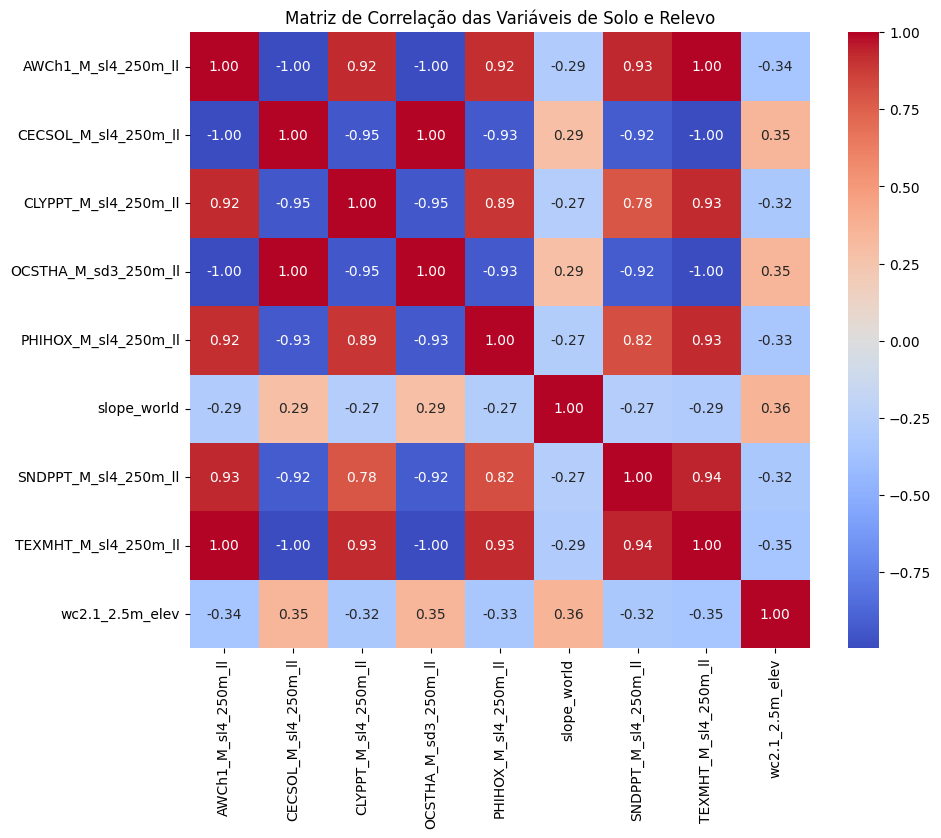

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista apenas com as variáveis de solo e relevo que foram adicionadas no teste anterior
variaveis_solo_relevo = [
    'AWCh1_M_sl4_250m_ll', 'CECSOL_M_sl4_250m_ll', 'CLYPPT_M_sl4_250m_ll', 
    'OCSTHA_M_sd3_250m_ll', 'PHIHOX_M_sl4_250m_ll', 'slope_world', 
    'SNDPPT_M_sl4_250m_ll', 'TEXMHT_M_sl4_250m_ll', 'wc2.1_2.5m_elev'
]

# Calcula a matriz de correlação
matriz_corr = variaveis_df[variaveis_solo_relevo].corr()

# Desenha o mapa de calor (heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação das Variáveis de Solo e Relevo')
plt.show()

In [30]:
# Lista final com as 11 variáveis selecionadas (6 climáticas + 5 de solo/relevo)
variaveis_finais_selecionadas = [
    # Climáticas (Prioritárias)
    'wc2.1_2.5m_bio_1',
    'wc2.1_2.5m_bio_4',
    'wc2.1_2.5m_bio_6',
    'wc2.1_2.5m_bio_12',
    'wc2.1_2.5m_bio_17',
    'wc2.1_2.5m_bio_18',
    # Solo e Relevo (Selecionadas Manualmente)
    'CLYPPT_M_sl4_250m_ll', # Textura
    'PHIHOX_M_sl4_250m_ll', # Química
    'AWCh1_M_sl4_250m_ll', # Água
    'slope_world',          # Relevo
    'wc2.1_2.5m_elev'       # Relevo
]


print("--- ✅ Seleção Manual de Variáveis Finalizada ---")
print(f"O processo resultou em um total de {len(variaveis_finais_selecionadas)} variáveis selecionadas:")
print("----------------------------------------------------------")
for var in variaveis_finais_selecionadas:
    print(f"- {var}")
print("----------------------------------------------------------")


# Montar o DataFrame final para salvar
# As variáveis 'pontos_df', 'COLUNA_LON' e 'COLUNA_LAT' já existem dos passos anteriores
colunas_para_salvar = [COLUNA_LON, COLUNA_LAT] + variaveis_finais_selecionadas
df_final = pontos_df[colunas_para_salvar].copy()

# Remove, por segurança, qualquer linha que possa ter valores nulos
df_final.dropna(inplace=True)

# Define um novo nome para o arquivo para não sobrescrever o anterior
NOME_ARQUIVO_SAIDA_MANUAL = 'features_selecionadas_MANUAL_laranja.csv'

# Salvar o arquivo CSV
caminho_completo_saida = os.path.join(PASTA_SAIDA_FEATURES, NOME_ARQUIVO_SAIDA_MANUAL)
df_final.to_csv(caminho_completo_saida, index=False)

print("\n\nArquivo com os dados organizados e features selecionadas manualmente foi salvo em:")
print(f"==> {caminho_completo_saida}")
print("\nProcesso concluído com sucesso!")

--- ✅ Seleção Manual de Variáveis Finalizada ---
O processo resultou em um total de 11 variáveis selecionadas:
----------------------------------------------------------
- wc2.1_2.5m_bio_1
- wc2.1_2.5m_bio_4
- wc2.1_2.5m_bio_6
- wc2.1_2.5m_bio_12
- wc2.1_2.5m_bio_17
- wc2.1_2.5m_bio_18
- CLYPPT_M_sl4_250m_ll
- PHIHOX_M_sl4_250m_ll
- AWCh1_M_sl4_250m_ll
- slope_world
- wc2.1_2.5m_elev
----------------------------------------------------------


Arquivo com os dados organizados e features selecionadas manualmente foi salvo em:
==> D:\ARTIGOS\2025\LARANJA_MAX\02_INTERMEDIARIOS\Features\features_selecionadas_MANUAL_laranja.csv

Processo concluído com sucesso!


In [31]:
import os
import shutil

# --- 1. CONFIGURAÇÃO ---

# A pasta onde estão TODOS os seus 28 rasters corrigidos
PASTA_ORIGEM_RASTERS = r"D:\ARTIGOS\2025\LARANJA_MAX\02_INTERMEDIARIOS\Rasters\bioclim\atual"

# A pasta de destino que queremos criar e popular
PASTA_DESTINO_RASTERS = r"D:\ARTIGOS\2025\LARANJA_MAX\02_INTERMEDIARIOS\Rasters\selecionados_final"

# A lista exata dos 11 nomes de variáveis que selecionamos (sem a extensão .tif)
NOMES_VARIAVEIS_SELECIONADAS = [
    'wc2.1_2.5m_bio_1',
    'wc2.1_2.5m_bio_4',
    'wc2.1_2.5m_bio_6',
    'wc2.1_2.5m_bio_12',
    'wc2.1_2.5m_bio_17',
    'wc2.1_2.5m_bio_18',
    'CLYPPT_M_sl4_250m_ll',
    'PHIHOX_M_sl4_250m_ll',
    'AWCh1_M_sl4_250m_ll',
    'slope_world',
    'wc2.1_2.5m_elev'
]

# --- 2. EXECUÇÃO DA CÓPIA ---

print(f"Criando a pasta de destino: {PASTA_DESTINO_RASTERS}")
os.makedirs(PASTA_DESTINO_RASTERS, exist_ok=True)

print("\nIniciando a cópia dos 11 rasters selecionados...")
arquivos_copiados = 0

for nome_base in NOMES_VARIAVEIS_SELECIONADAS:
    # Monta o nome completo do arquivo de origem
    nome_arquivo = f"{nome_base}.tif"
    caminho_origem = os.path.join(PASTA_ORIGEM_RASTERS, nome_arquivo)
    
    # Monta o caminho de destino
    caminho_destino = os.path.join(PASTA_DESTINO_RASTERS, nome_arquivo)
    
    # Verifica se o arquivo de origem existe antes de copiar
    if os.path.exists(caminho_origem):
        print(f"  Copiando '{nome_arquivo}'...")
        shutil.copy(caminho_origem, caminho_destino)
        arquivos_copiados += 1
    else:
        print(f"  AVISO: Arquivo '{nome_arquivo}' não encontrado na pasta de origem.")

print(f"\n--- ✅ Concluído! ---")
print(f"Total de {arquivos_copiados} de 11 arquivos copiados para a pasta 'selecionados_final'.")

Criando a pasta de destino: D:\ARTIGOS\2025\LARANJA_MAX\02_INTERMEDIARIOS\Rasters\selecionados_final

Iniciando a cópia dos 11 rasters selecionados...
  Copiando 'wc2.1_2.5m_bio_1.tif'...
  Copiando 'wc2.1_2.5m_bio_4.tif'...
  Copiando 'wc2.1_2.5m_bio_6.tif'...
  Copiando 'wc2.1_2.5m_bio_12.tif'...
  Copiando 'wc2.1_2.5m_bio_17.tif'...
  Copiando 'wc2.1_2.5m_bio_18.tif'...
  Copiando 'CLYPPT_M_sl4_250m_ll.tif'...
  Copiando 'PHIHOX_M_sl4_250m_ll.tif'...
  Copiando 'AWCh1_M_sl4_250m_ll.tif'...
  Copiando 'slope_world.tif'...
  Copiando 'wc2.1_2.5m_elev.tif'...

--- ✅ Concluído! ---
Total de 11 de 11 arquivos copiados para a pasta 'selecionados_final'.
